# Chapter 6: The Haunted DAG & The Causal Terror - Samples

Imagine how selecting topics for a conference works. Imagine that we are scoring with equal weights on two variables:

* Trustworthiness
* Newsworthiness

Let's simulate:

### Code 6.1

In [4]:
import numpy as np
from scipy import stats

np.random.seed(42)
N = 200
p = 0.1
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw
q = np.quantile(s, 1-p)
selected = np.where(s >= q, True, False)
stats.pearsonr(tw[selected], nw[selected])

PearsonRResult(statistic=-0.702031027987863, pvalue=0.0005597087444959316)

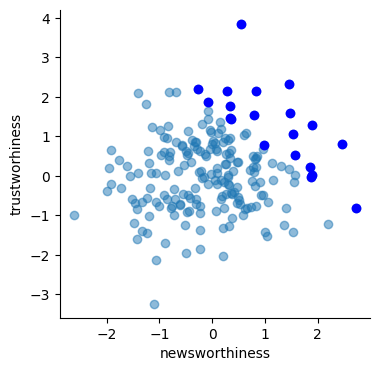

In [19]:
from matplotlib import pyplot as plt


plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.plot(nw, tw, 'o', alpha=0.5)
ax.plot(nw[selected], tw[selected], 'bo');
ax.set_xlabel('newsworthiness')
ax.set_ylabel('trustworhiness')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

Among funded proposals, the most newsworthy studies can actually have less than average trustworhiness (less than 0 in the figure). 

This phenomenon is called the <span style="color:blue">BERKSON'S PARADOX</span>. Is is also known as the **selection-distortion effect**.

Regression will not help finding these scenarios because the act of adding a predictor induces statistical selection within the model, also known as <span style="color:blue">COLLIDER BIAS</span>.